In [1]:
import json
import pandas as pd

In [2]:
# read csv file
df = pd.read_csv('labels.csv')

In [3]:
df.head()

,file_name,height,width,bbox,age,race,masked,skintone,emotion,gender
0,100013282.jpg,1333,2000,"[934.0000000000097, 144.82228672769534, 238.24...",20-30s,Caucasian,unmasked,mid-light,Neutral,Male
1,100016175.jpg,1333,2000,"[1094.0513571635438, 422.91772295627203, 55.45...",20-30s,Caucasian,unmasked,light,Neutral,Male
2,10004189.jpg,2000,1333,"[419.93871061403877, 269.1250391680045, 377.19...",20-30s,Mongoloid,unmasked,light,Happiness,Female
3,100104575.jpg,1333,2000,"[1490.6909678848915, 676.0000000000097, 37.553...",20-30s,Caucasian,unmasked,mid-light,Neutral,Male
4,100104600.jpg,2000,1333,"[549.169724453414, 92.52040334013152, 306.8821...",20-30s,Caucasian,unmasked,mid-light,Happiness,Female


In [4]:
label_cols = ['age', 'race', 'masked', 'skintone', 'emotion', 'gender']

In [30]:
for col in label_cols:
    values = df[col].value_counts(normalize=True)
    num_values = len(values)

    s = 0

    for i in range(num_values):
        s += 1 / values[i]

    for i in range(num_values):
        values[i] = 1 / (s * values[i])

    l = '['
    for i in range(num_values):
        # 4 decimal places
        l += str(round(values[i], 4)) + ', '
    l = l[:-2] + ']'

    print(values)
    print(col + ' = ' + l)

age
20-30s      0.010994
40-50s      0.077107
Kid         0.129481
Senior      0.193917
Teenager    0.230457
Baby        0.358044
Name: proportion, dtype: float64
age = [0.011, 0.0771, 0.1295, 0.1939, 0.2305, 0.358]
race
Mongoloid    0.080027
Caucasian    0.084318
Negroid      0.835655
Name: proportion, dtype: float64
race = [0.08, 0.0843, 0.8357]
masked
unmasked    0.03292
masked      0.96708
Name: proportion, dtype: float64
masked = [0.0329, 0.9671]
skintone
light        0.020872
mid-light    0.059339
mid-dark     0.274238
dark         0.645551
Name: proportion, dtype: float64
skintone = [0.0209, 0.0593, 0.2742, 0.6456]
emotion
Happiness    0.004216
Neutral      0.008024
Sadness      0.102279
Anger        0.121838
Surprise     0.128271
Disgust      0.294441
Fear         0.340931
Name: proportion, dtype: float64
emotion = [0.0042, 0.008, 0.1023, 0.1218, 0.1283, 0.2944, 0.3409]
gender
Female    0.312737
Male      0.687263
Name: proportion, dtype: float64
gender = [0.3127, 0.6873]


In [6]:
for col in label_cols:
    print(sorted(df[col].unique()))

['20-30s', '40-50s', 'Baby', 'Kid', 'Senior', 'Teenager']
['Caucasian', 'Mongoloid', 'Negroid']
['masked', 'unmasked']
['dark', 'light', 'mid-dark', 'mid-light']
['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']
['Female', 'Male']


In [7]:
label_maps = {
    'age': ["Baby", "Kid", "Teenager", "20-30s", "40-50s", "Senior"],
    'race': ['Caucasian', 'Mongoloid', 'Negroid'],
    'masked': ['unmasked', 'masked'],
    'skintone': ["light", "mid-light", "mid-dark", "dark"],
    'emotion': ["Neutral", "Happiness", "Surprise", "Sadness", "Fear", "Disgust", "Anger"],
    'gender': ['Male', 'Female']
}

temp = {}
for k in label_maps.keys():
    value = {}
    for i, v in enumerate(label_maps[k]):
        value[v] = i
    temp[k] = value
label_maps = temp
label_maps

{'age': {'Baby': 0,
  'Kid': 1,
  'Teenager': 2,
  '20-30s': 3,
  '40-50s': 4,
  'Senior': 5},
 'race': {'Caucasian': 0, 'Mongoloid': 1, 'Negroid': 2},
 'masked': {'unmasked': 0, 'masked': 1},
 'skintone': {'light': 0, 'mid-light': 1, 'mid-dark': 2, 'dark': 3},
 'emotion': {'Neutral': 0,
  'Happiness': 1,
  'Surprise': 2,
  'Sadness': 3,
  'Fear': 4,
  'Disgust': 5,
  'Anger': 6},
 'gender': {'Male': 0, 'Female': 1}}

In [8]:
targets = {}

for i in range(len(df)):
    row = df.iloc[i]
    key = row['file_name']
    
    if key not in targets:
        targets[key] = {
            'id': len(targets),
            'file_name': key,
            'height': int(row['height']),
            'width': int(row['width']),
            'faces': []
        }

    face = { k: label_maps[k][row[k]] for k in label_cols }
    face['box'] = json.loads(row['bbox'])

    targets[key]['faces'].append(face)


In [9]:
# number of images with multiple faces
print(len([k for k in targets if len(targets[k]['faces']) > 1]))

109


In [10]:
# split into train and test
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

TRAIN_VAL_TEST_SPLIT = [0.8, 0.1, 0.1]

train_val, test = train_test_split(list(targets.values()), test_size=TRAIN_VAL_TEST_SPLIT[2], random_state=42)
train, val = train_test_split(train_val, test_size=TRAIN_VAL_TEST_SPLIT[1] / (TRAIN_VAL_TEST_SPLIT[0] + TRAIN_VAL_TEST_SPLIT[1]), random_state=42)

In [11]:
def visualize_distribution(targets):
    """Visualize the distribution of each label in unique values in 1x6 grid"""

    fig, axes = plt.subplots(1, 6, figsize=(20, 3))
    for i, col in enumerate(label_cols):
        axes[i].hist([face[col] for target in targets for face in target['faces']])
        axes[i].set_title(col)
    plt.show()

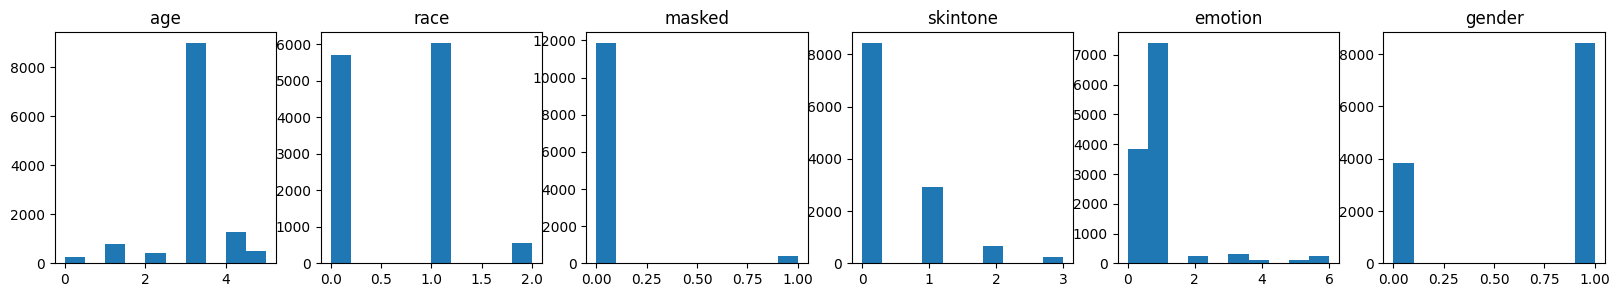

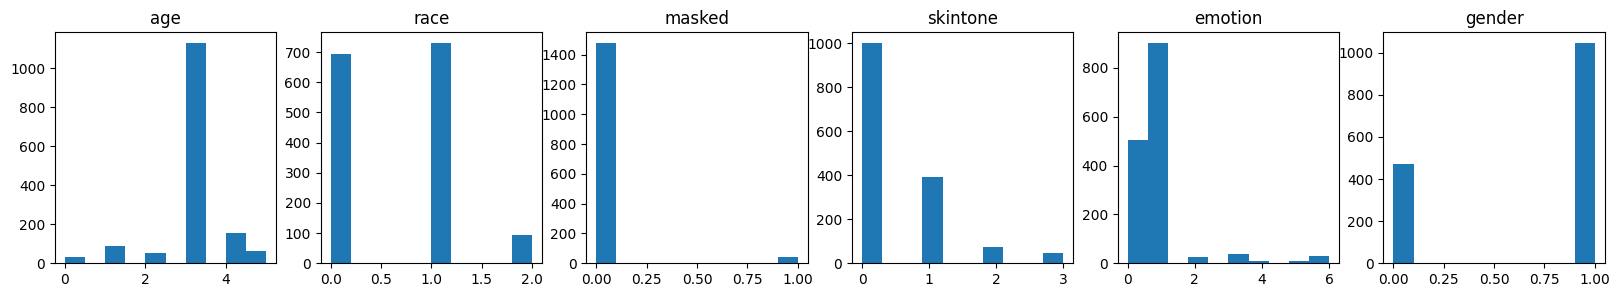

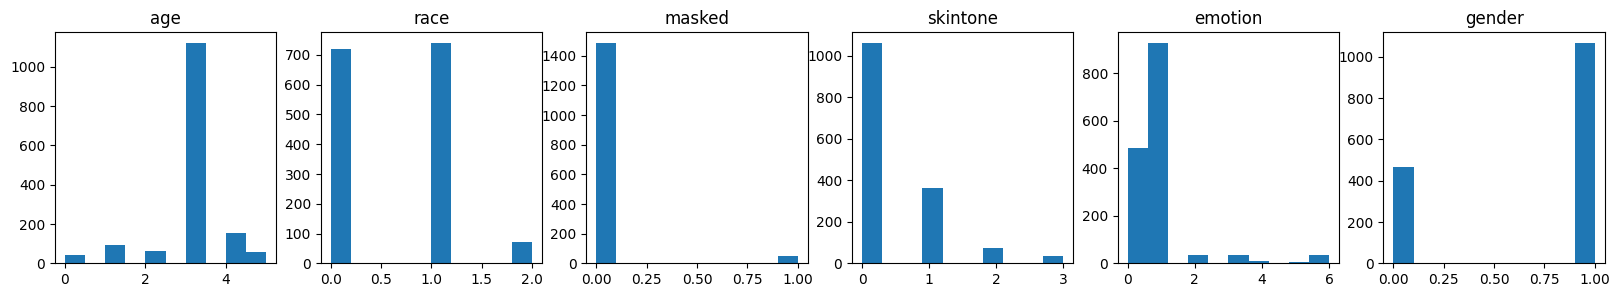

In [12]:
visualize_distribution(train)
visualize_distribution(val)
visualize_distribution(test)

In [13]:
# dump json
with open('labels.json', 'w') as f:
    data = {
        'images': list(targets.values()),
        'train': sorted([t['id'] for t in train]),
        'val': sorted([t['id'] for t in val]),
        'test': sorted([t['id'] for t in test])
    }
    data['categories'] = {k: list(v.keys()) for k, v in label_maps.items()}
    json.dump(data, f, indent=4)

In [6]:
import torch, setup

In [7]:
data = torch.load('../checkpoints/last.ckpt')

/home/qninhdt/miniconda3/envs/cctv-od/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# remove state with '.total_ops' and '.total_params'

for k in list(data['state_dict'].keys()):
    if '.total_ops' in k or '.total_params' in k:
        del data['state_dict'][k]

        

In [11]:
data['state_dict'].keys()

odict_keys(['model.backbone.stem.0.conv.weight', 'model.backbone.stem.0.norm.weight', 'model.backbone.stem.0.norm.bias', 'model.backbone.stem.0.norm.running_mean', 'model.backbone.stem.0.norm.running_var', 'model.backbone.stem.0.norm.num_batches_tracked', 'model.backbone.stem.1.conv.weight', 'model.backbone.stem.1.norm.weight', 'model.backbone.stem.1.norm.bias', 'model.backbone.stem.1.norm.running_mean', 'model.backbone.stem.1.norm.running_var', 'model.backbone.stem.1.norm.num_batches_tracked', 'model.backbone.stem.2.conv.weight', 'model.backbone.stem.2.norm.weight', 'model.backbone.stem.2.norm.bias', 'model.backbone.stem.2.norm.running_mean', 'model.backbone.stem.2.norm.running_var', 'model.backbone.stem.2.norm.num_batches_tracked', 'model.backbone.stage1.0.conv.weight', 'model.backbone.stage1.0.norm.weight', 'model.backbone.stage1.0.norm.bias', 'model.backbone.stage1.0.norm.running_mean', 'model.backbone.stage1.0.norm.running_var', 'model.backbone.stage1.0.norm.num_batches_tracked', 

In [ ]:
# save new checkpoint
torch.save(data, '../checkpoints/last.ckpt')